In [1]:
import numpy as np
import pandas as pd
import keras as k
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = (10,10)
rcParams["lines.linewidth"] = 2 
plt.style.use("ggplot")

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

import warnings
warnings.filterwarnings('ignore')

In [15]:
#loading from the file
df = pd.read_csv('ethereum.csv')
#checking the data - first and last 5
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Currency'], dtype='object')

In [16]:
df.head(20)

Date   Open   High    Low  Close  Volume Currency
0   2016-03-10  11.20  11.85  11.07  11.75       4      USD
1   2016-03-11  11.75  11.95  11.75  11.95     179      USD
2   2016-03-12  11.95  13.45  11.95  12.92     833      USD
3   2016-03-13  12.92  15.07  12.92  15.07    1295      USD
4   2016-03-14  15.07  15.07  11.40  12.50   92183      USD
5   2016-03-15  12.63  13.42  11.98  13.06   39725      USD
6   2016-03-16  13.06  13.89  12.62  12.88   19240      USD
7   2016-03-17  12.58  12.61  10.44  10.74   89450      USD
8   2016-03-18  11.09  11.20   8.34  10.74  157374      USD
9   2016-03-19  10.97  11.10   9.78  10.31   67547      USD
10  2016-03-20  10.55  10.88   9.56  10.18   33177      USD
11  2016-03-21  10.18  12.05  10.14  11.95   38857      USD
12  2016-03-22  11.53  11.97  11.08  11.37   26285      USD
13  2016-03-23  11.37  12.43  11.20  12.43   27024      USD
14  2016-03-24  12.43  12.47  10.67  11.20   50796      USD
15  2016-03-25  11.32  11.35  10.52  10.67   87423      USD
16  2016-03-26  10.67  11.20  10.58  11.00   16125      USD
17  2016-03-27  10.93  10.98  10.17  10.40   55815      USD
18  2016-03-28  10.40  11.94  10.40  11.62   77312      USD
19  2016-03-29  11.78  11.88  11.37  11.79   47572      USD

# exploratory analysis

1. checking the data


In [17]:
#checking for null values in the data
df.isna().mean()

Date        0.0
Open        0.0
High        0.0
Low         0.0
Close       0.0
Volume      0.0
Currency    0.0
dtype: float64

In [9]:

from pandas_profiling import ProfileReport as Prt
profile = Prt(df, title="Report")
profile

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
#setting Date as index
df['Date'] = pd.to_datetime(df.Date, dayfirst=True)
df.set_index('Date', inplace=True)


In [20]:
# converting the TimeSeries to include time specified frequency and usinng backfill method
df = df.asfreq('d')
df = df.fillna(method = 'bfill')

2.Plotting the variables against time

Text(0.5, 1.0, 'Opening Price')

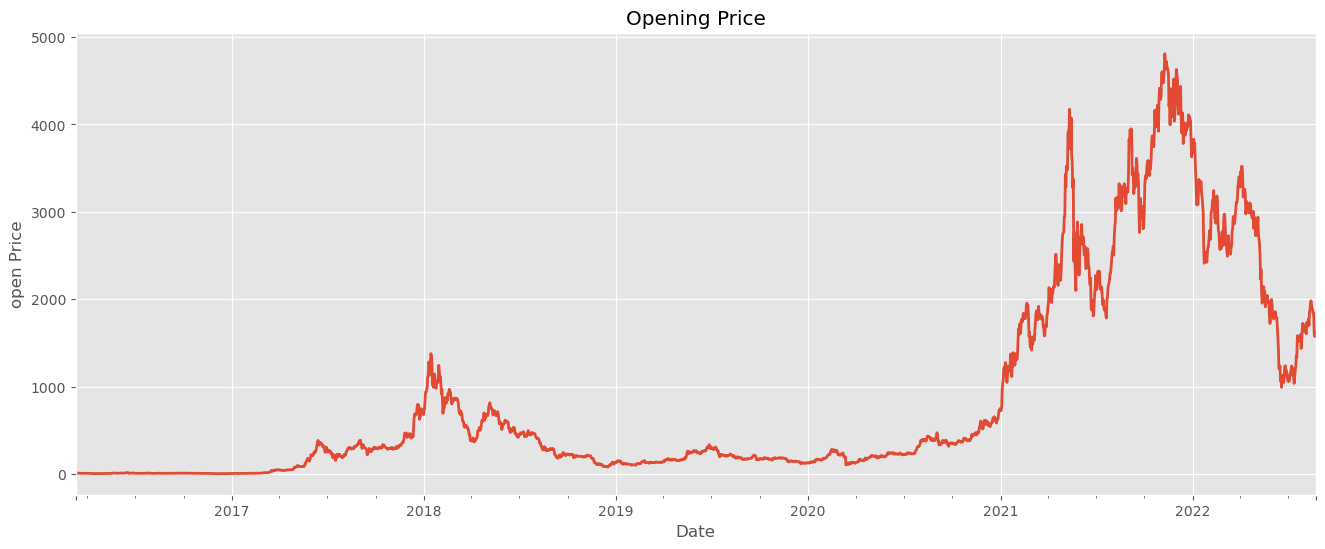

In [21]:
df['Open'].plot(figsize=(16,6))
plt.ylabel('open Price')
plt.title('Opening Price')

Text(0.5, 1.0, 'High Price')

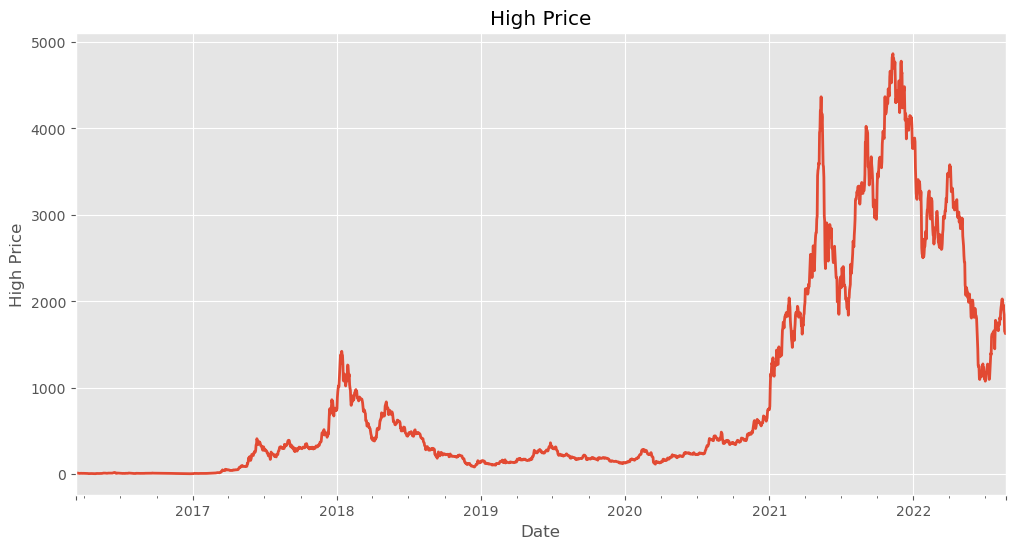

In [22]:
df['High'].plot(figsize=(12,6))
plt.ylabel('High Price')
plt.title('High Price')

Text(0.5, 1.0, 'Low Price')

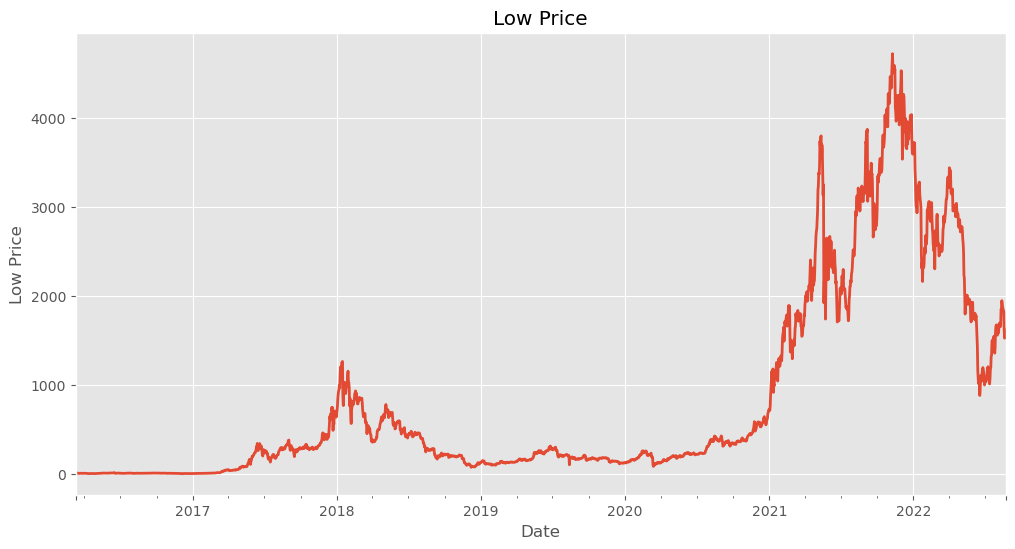

In [23]:
df['Low'].plot(figsize=(12,6))
plt.ylabel('Low Price')
plt.title('Low Price')

Text(0.5, 1.0, 'Closing Price')

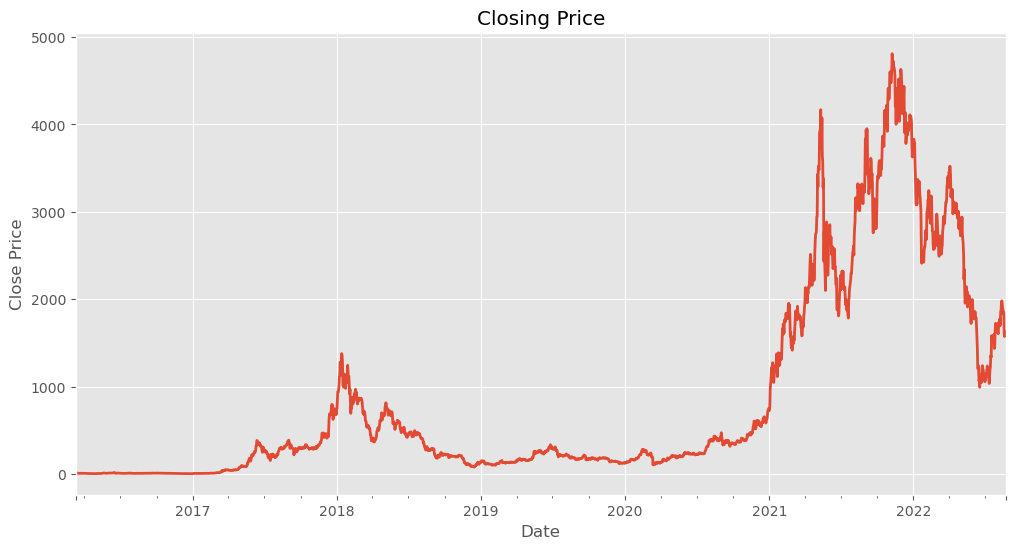

In [24]:
df['Close'].plot(figsize=(12,6))
plt.ylabel('Close Price')
plt.title('Closing Price')

Text(0.5, 1.0, 'Volume Price')

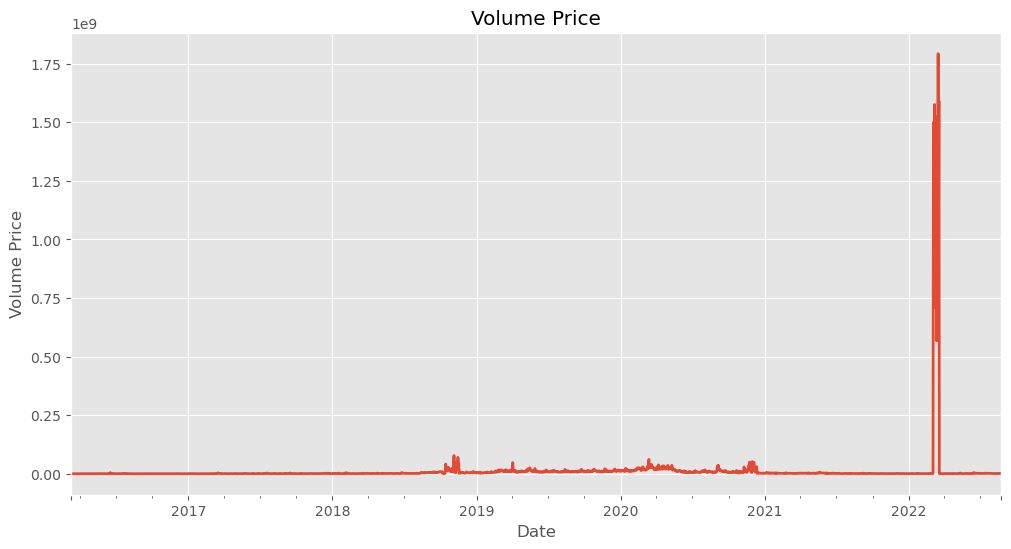

In [25]:
df['Volume'].plot(figsize=(12,6))
plt.ylabel('Volume Price')
plt.title('Volume Price')

In [26]:
df['Total Pov'] = df.sum(axis=1)

Text(0.5, 1.0, 'Total Portfolio Value')

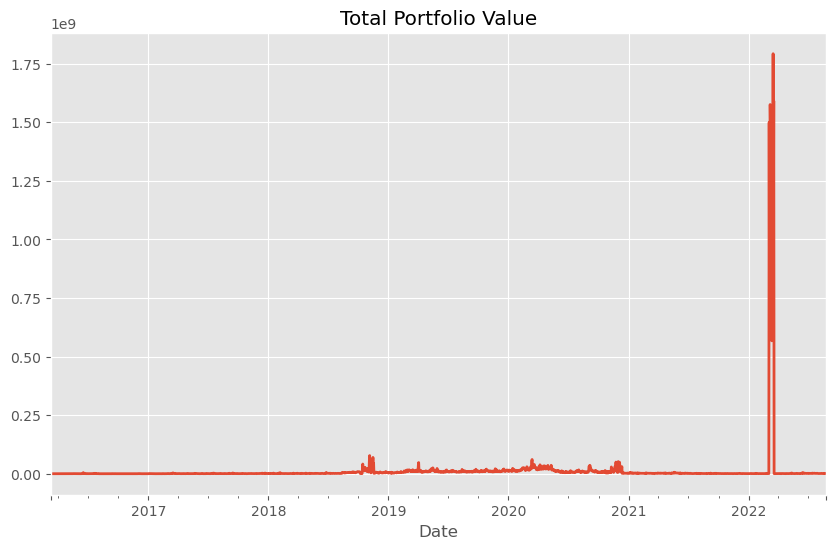

In [27]:
df['Total Pov'].plot(figsize=(10,6))
plt.title('Total Portfolio Value')

In [28]:
df['Daily Return'] = df['Total Pov'].pct_change(1)

In [29]:
df['Daily Return'].mean()

5.595478130870237

<AxesSubplot:ylabel='Density'>

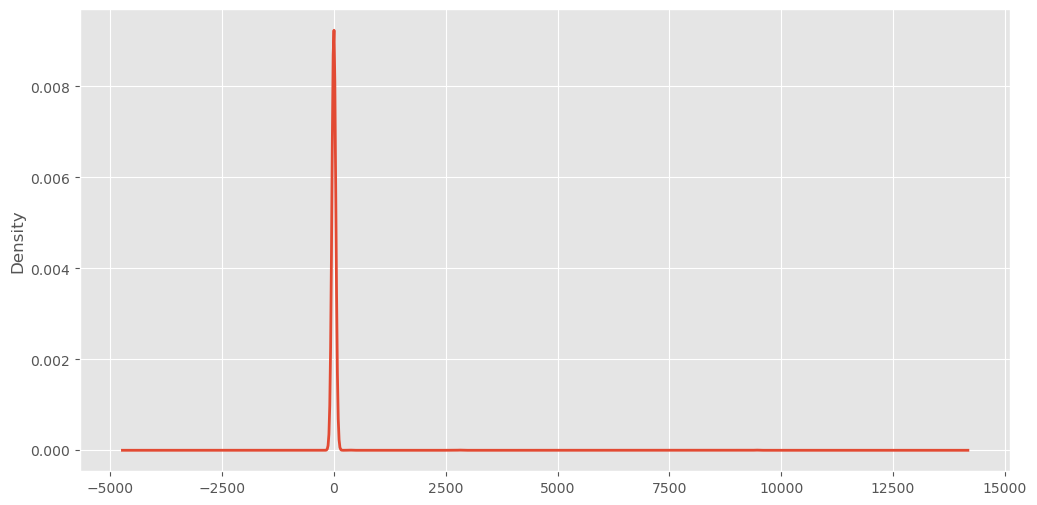

In [30]:
df['Daily Return'].plot(kind='kde', figsize=(12,6))

In [31]:
SR = df['Daily Return'].mean()/df['Daily Return'].std()
SR

0.027545452617819235

In [32]:
df = df.drop('Currency', axis=1)

<AxesSubplot:xlabel='Date'>

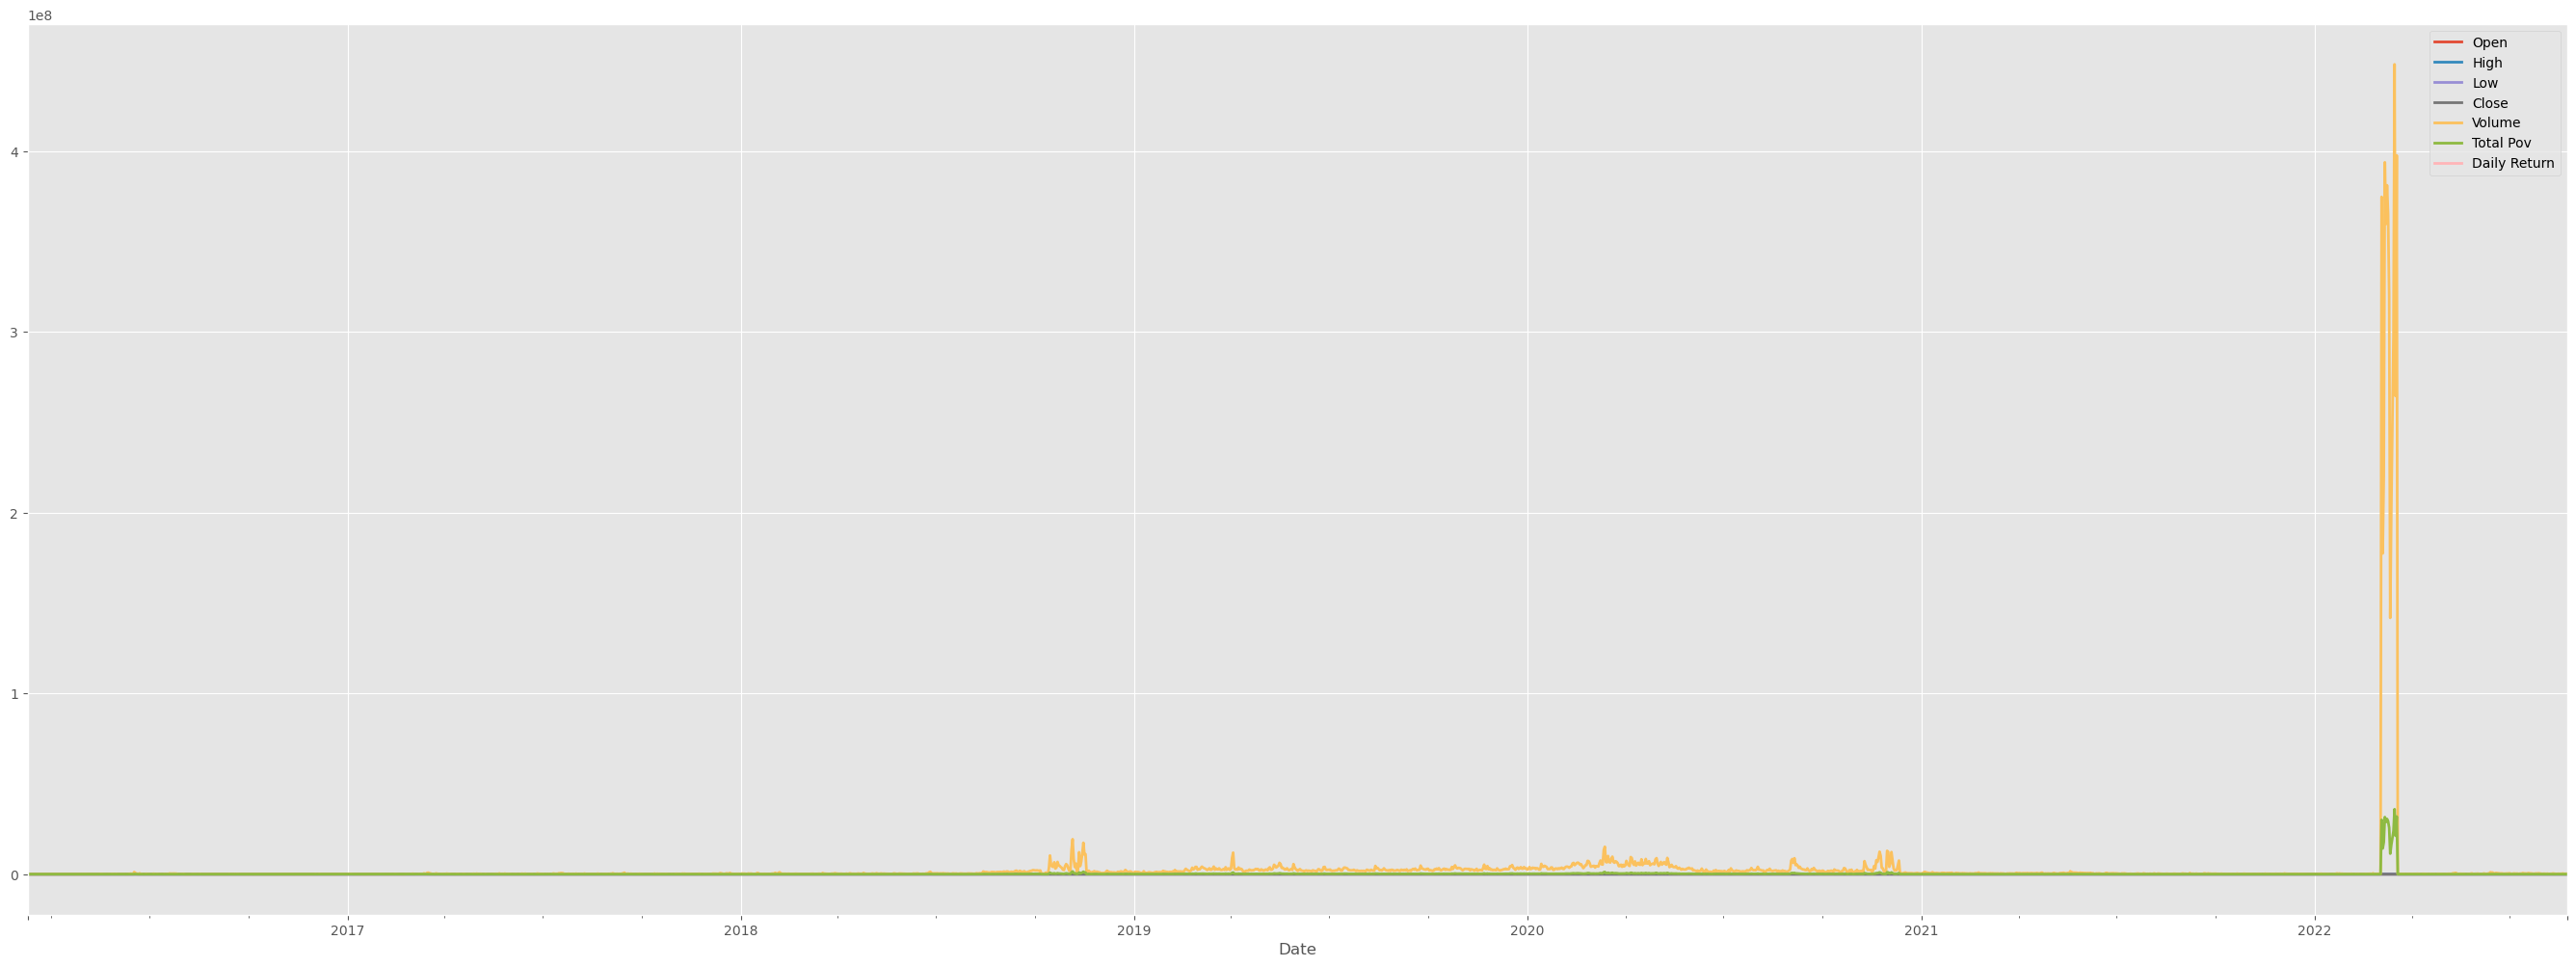

In [33]:
all_plt = df/df.iloc[0]
all_plt.plot(figsize=(34,12))

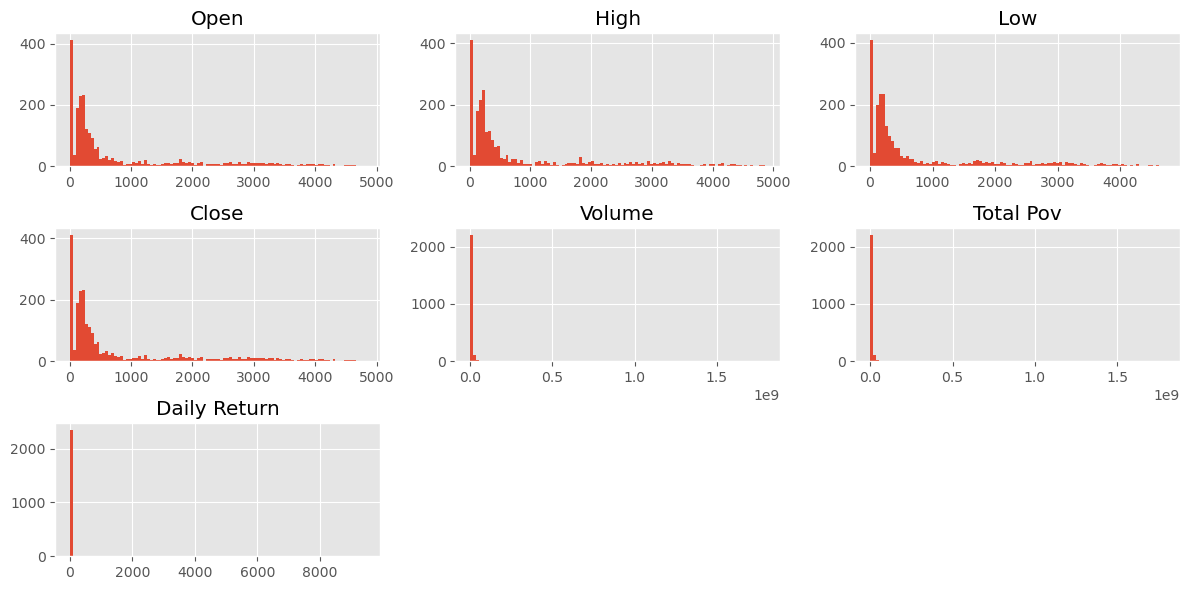

In [34]:
#3. histograms
df.hist(bins=100, figsize=(12,6));
plt.tight_layout()

In [35]:
df.resample(rule='A').mean()

Open         High          Low        Close        Volume  \
Date                                                                           
2016-12-31    11.157744    11.557340    10.709731    11.142660  2.197090e+05   
2017-12-31   218.340959   230.076685   206.164137   220.337370  6.182302e+05   
2018-12-31   482.989562   501.888740   458.714932   481.328575  4.572394e+06   
2019-12-31   180.998822   186.272685   175.172712   180.992986  1.009304e+07   
2020-12-31   305.653033   315.490164   295.880765   307.296776  1.414565e+07   
2021-12-31  2769.433151  2871.178164  2654.274822  2777.395151  1.449899e+06   
2022-12-31  2342.909319  2412.082000  2261.134213  2334.136766  7.907965e+07   

               Total Pov  Daily Return  
Date                                    
2016-12-31  2.197536e+05     32.733074  
2017-12-31  6.191051e+05      1.240810  
2018-12-31  4.574319e+06      0.142775  
2019-12-31  1.009376e+07      0.038522  
2020-12-31  1.414688e+07      0.074507  
2021-12-31  1.460972e+06      0.329114  
2022-12-31  7.908900e+07     12.055689

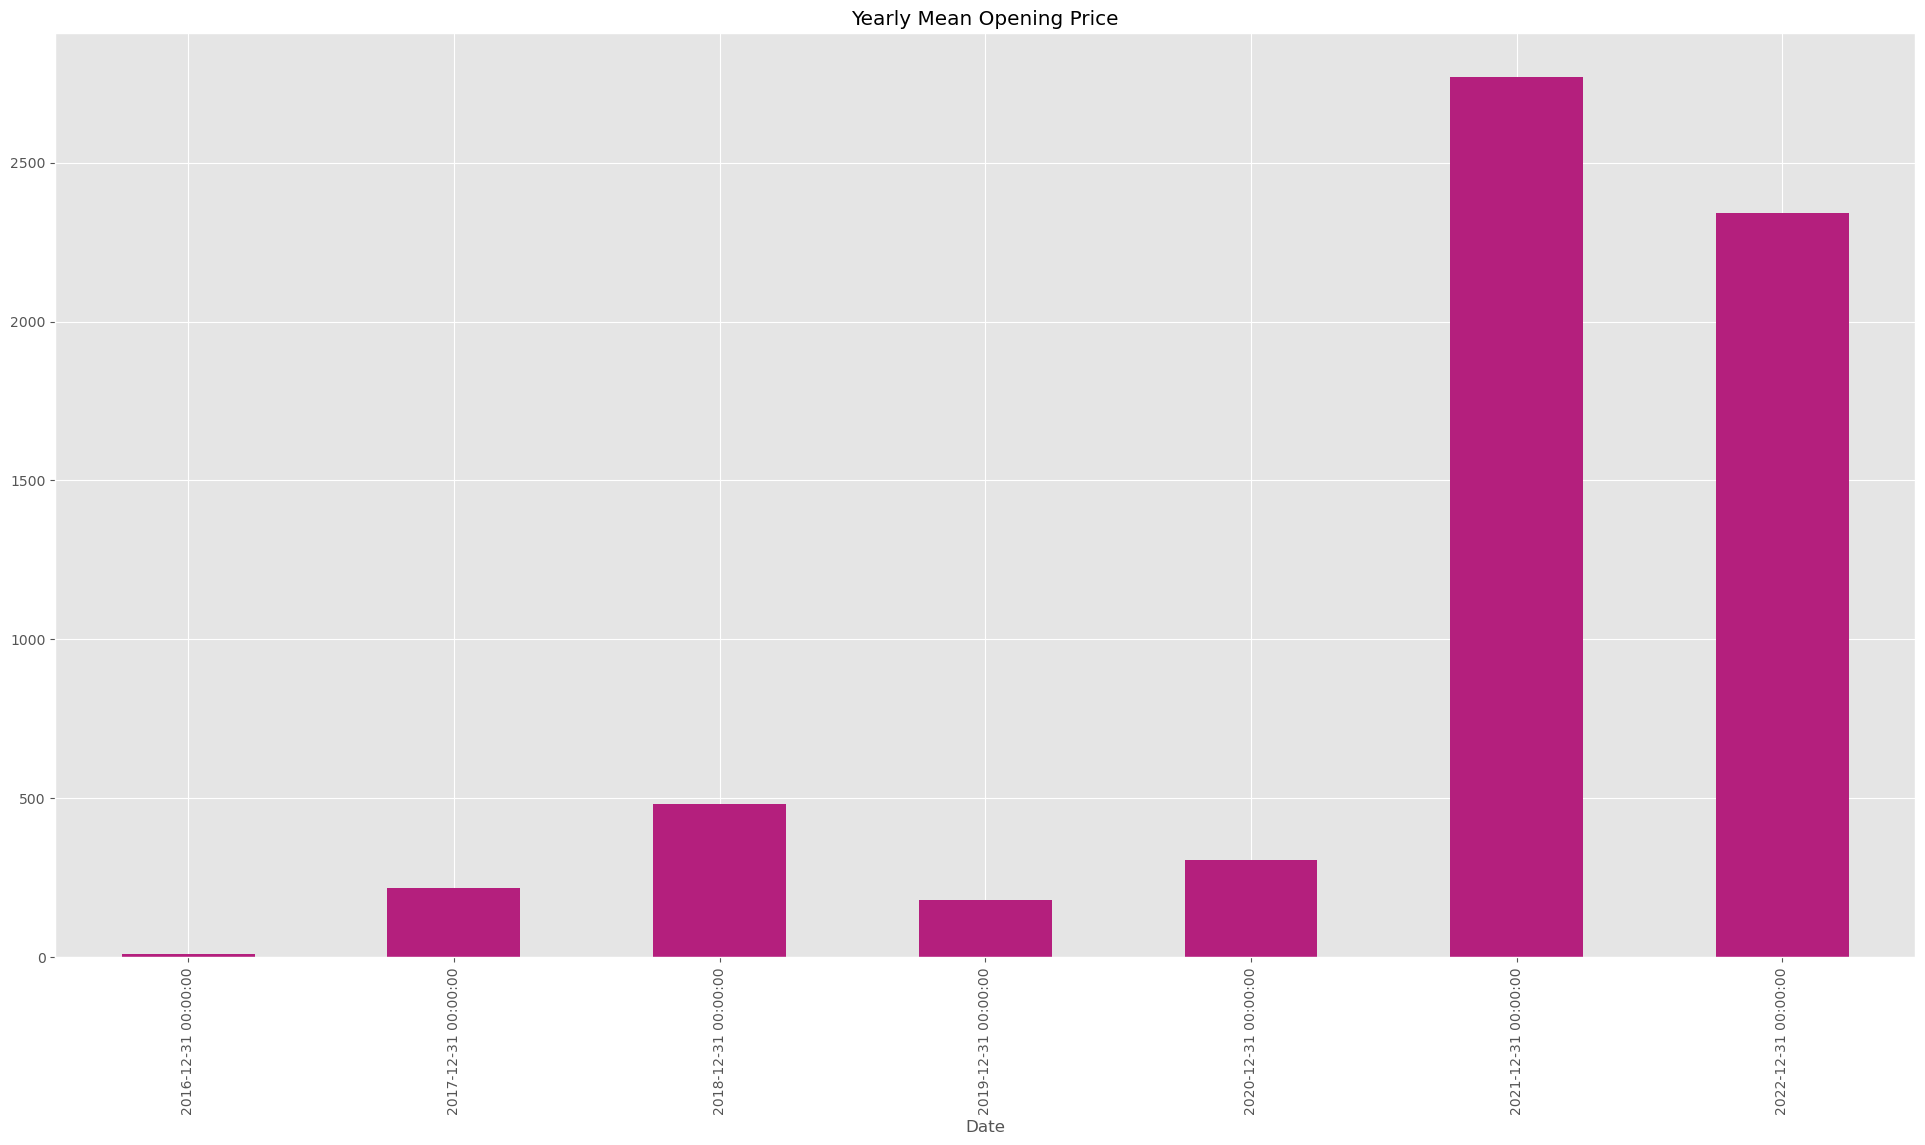

In [36]:
df['Open'].resample(rule='A').mean().plot.bar(title='Yearly Mean Opening Price', color=['#b41f7d'], figsize=(24,12));

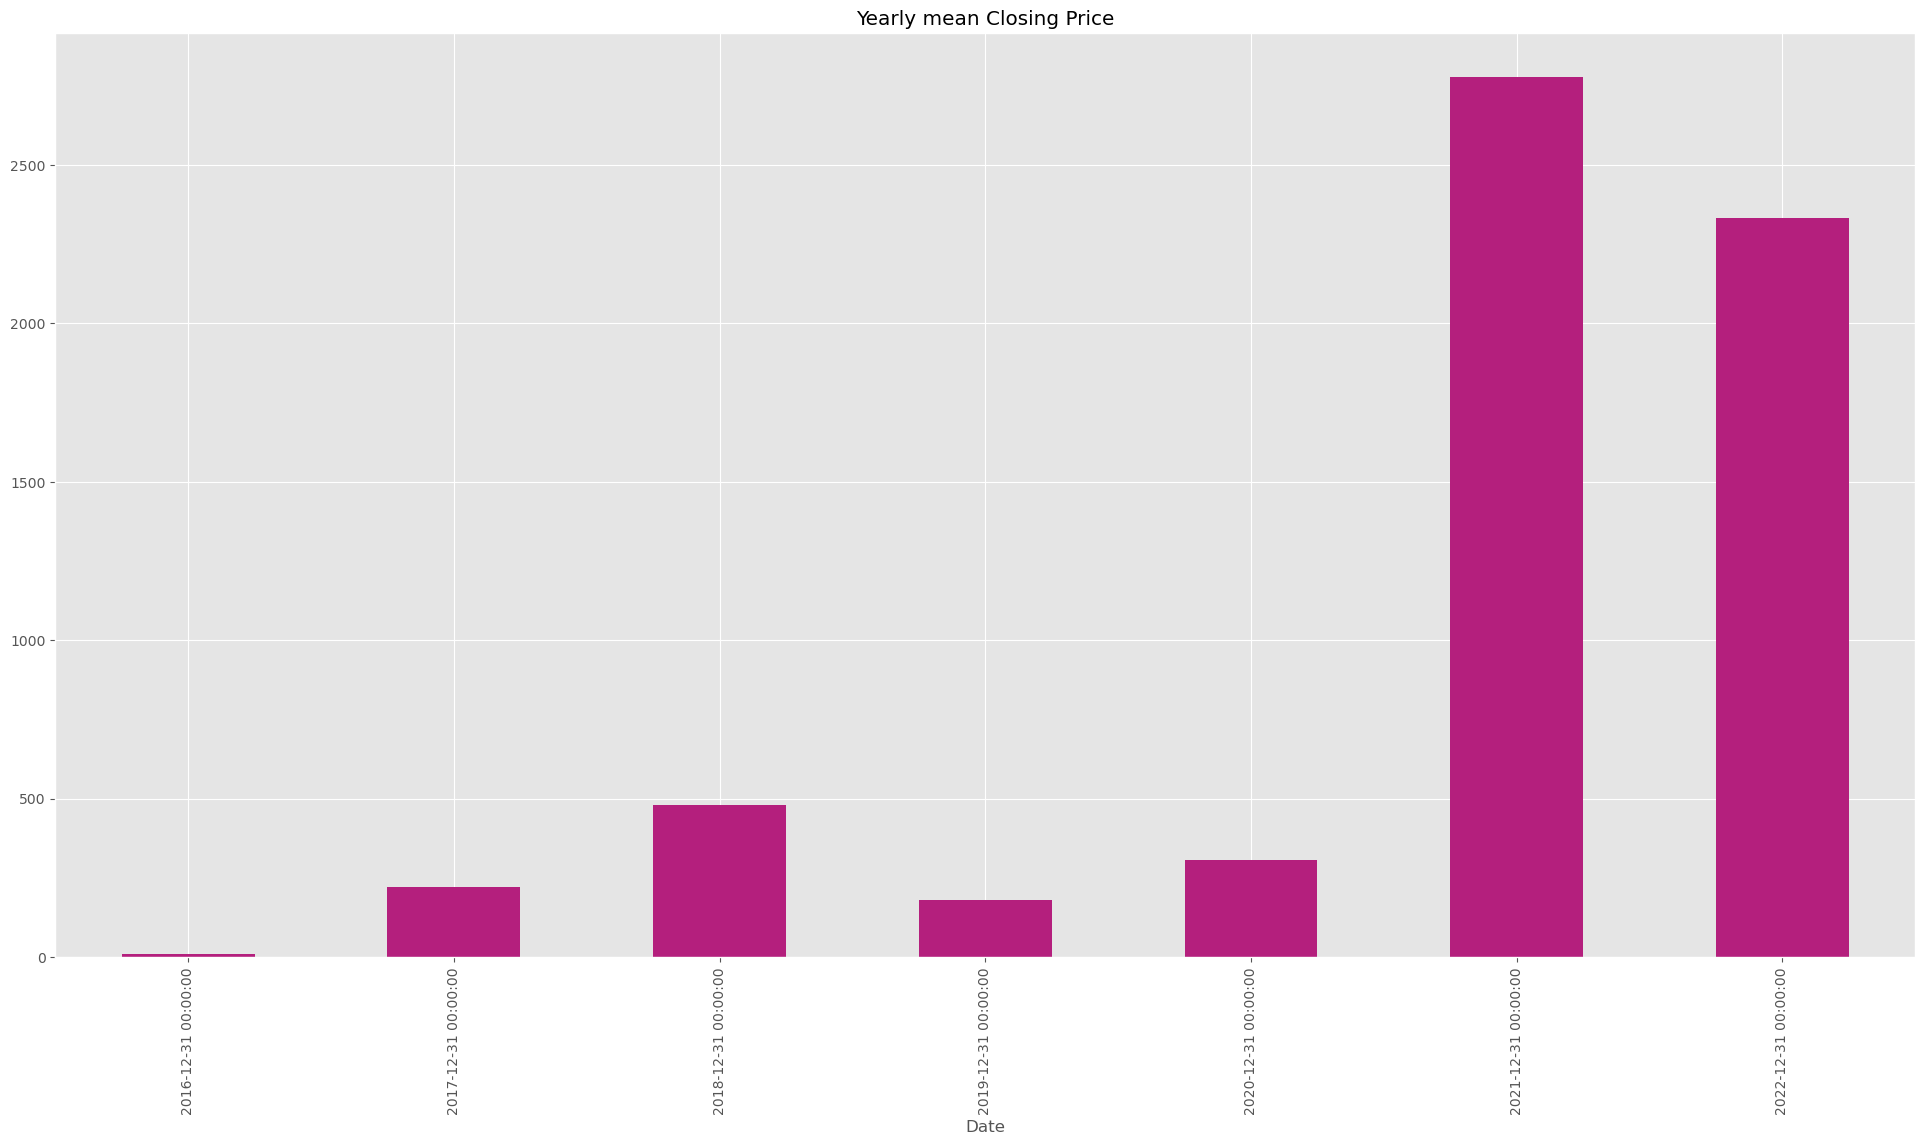

In [37]:
df['Close'].resample(rule='A').mean().plot.bar(title='Yearly mean Closing Price', color=['#b41f7d'],  figsize=(24,12));

In [38]:
df['6-month-SMA']  = df['Open'].rolling(window=6).mean()
df['12-month-SMA'] = df['Open'].rolling(window=12).mean()
df['2-month-SMA']  = df['Open'].rolling(window=2).mean()

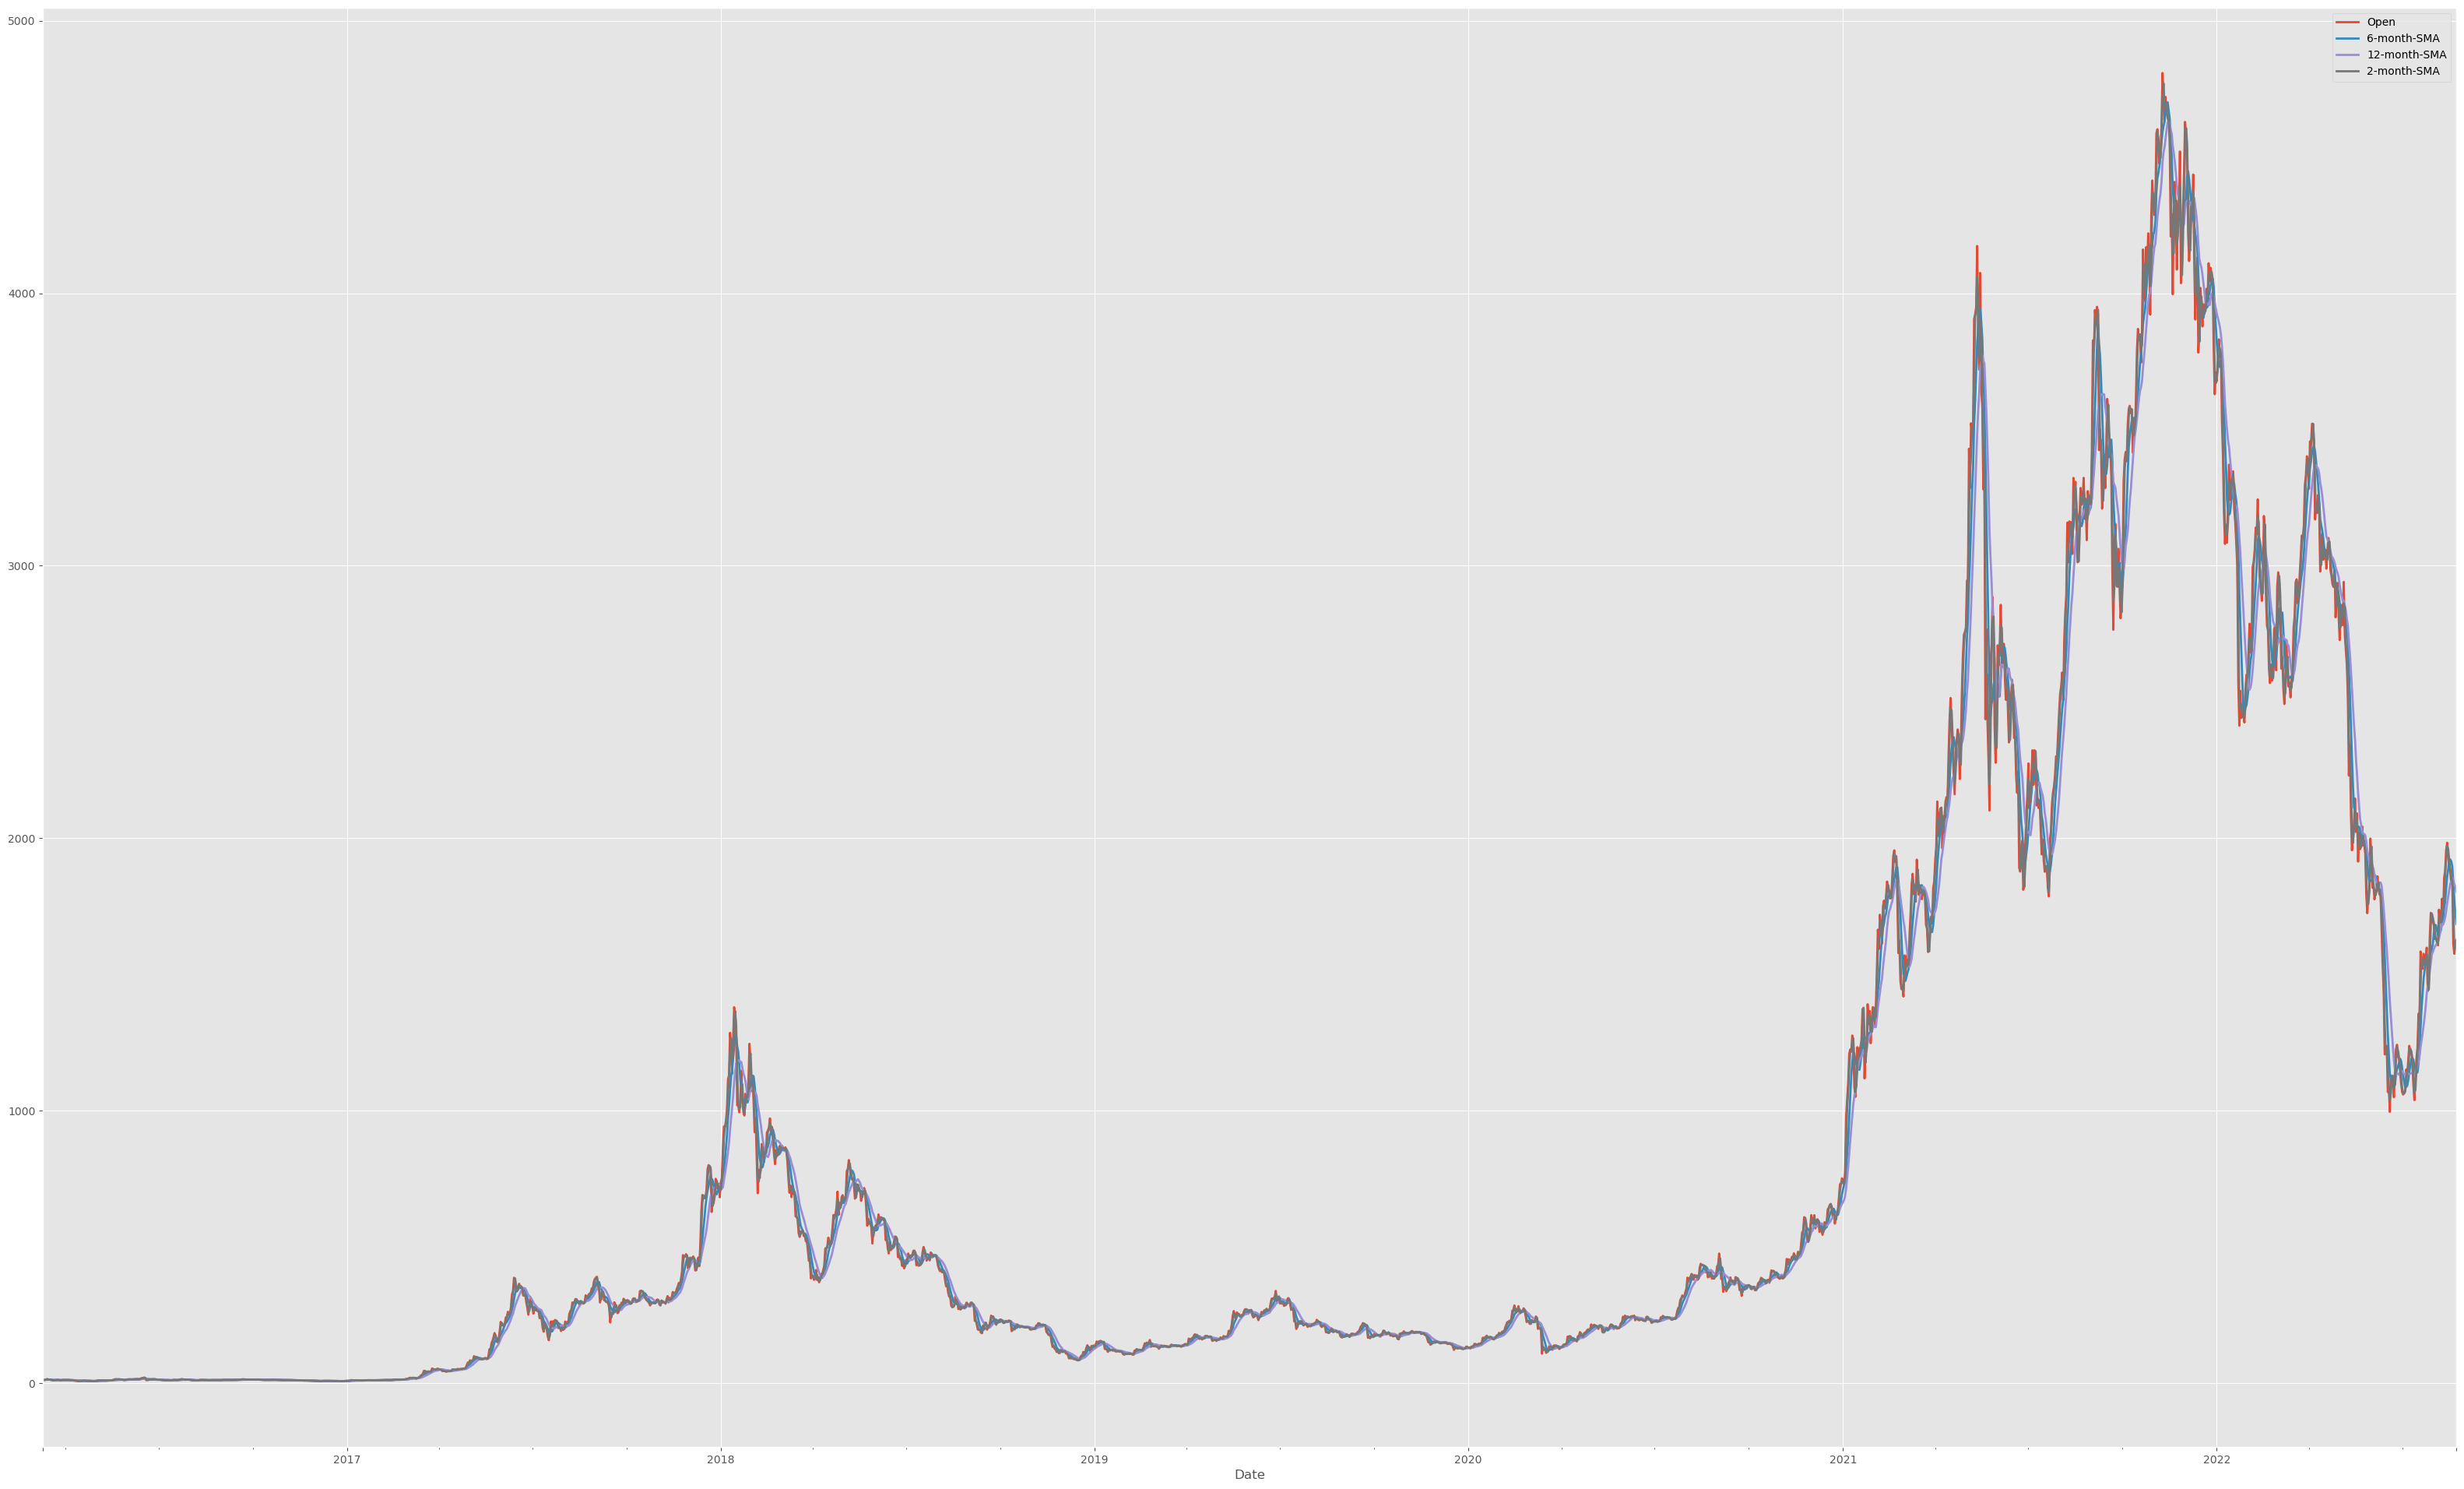

In [39]:
df[['Open', '6-month-SMA', '12-month-SMA', '2-month-SMA']].plot(figsize=(40,24));

<AxesSubplot:xlabel='Date'>

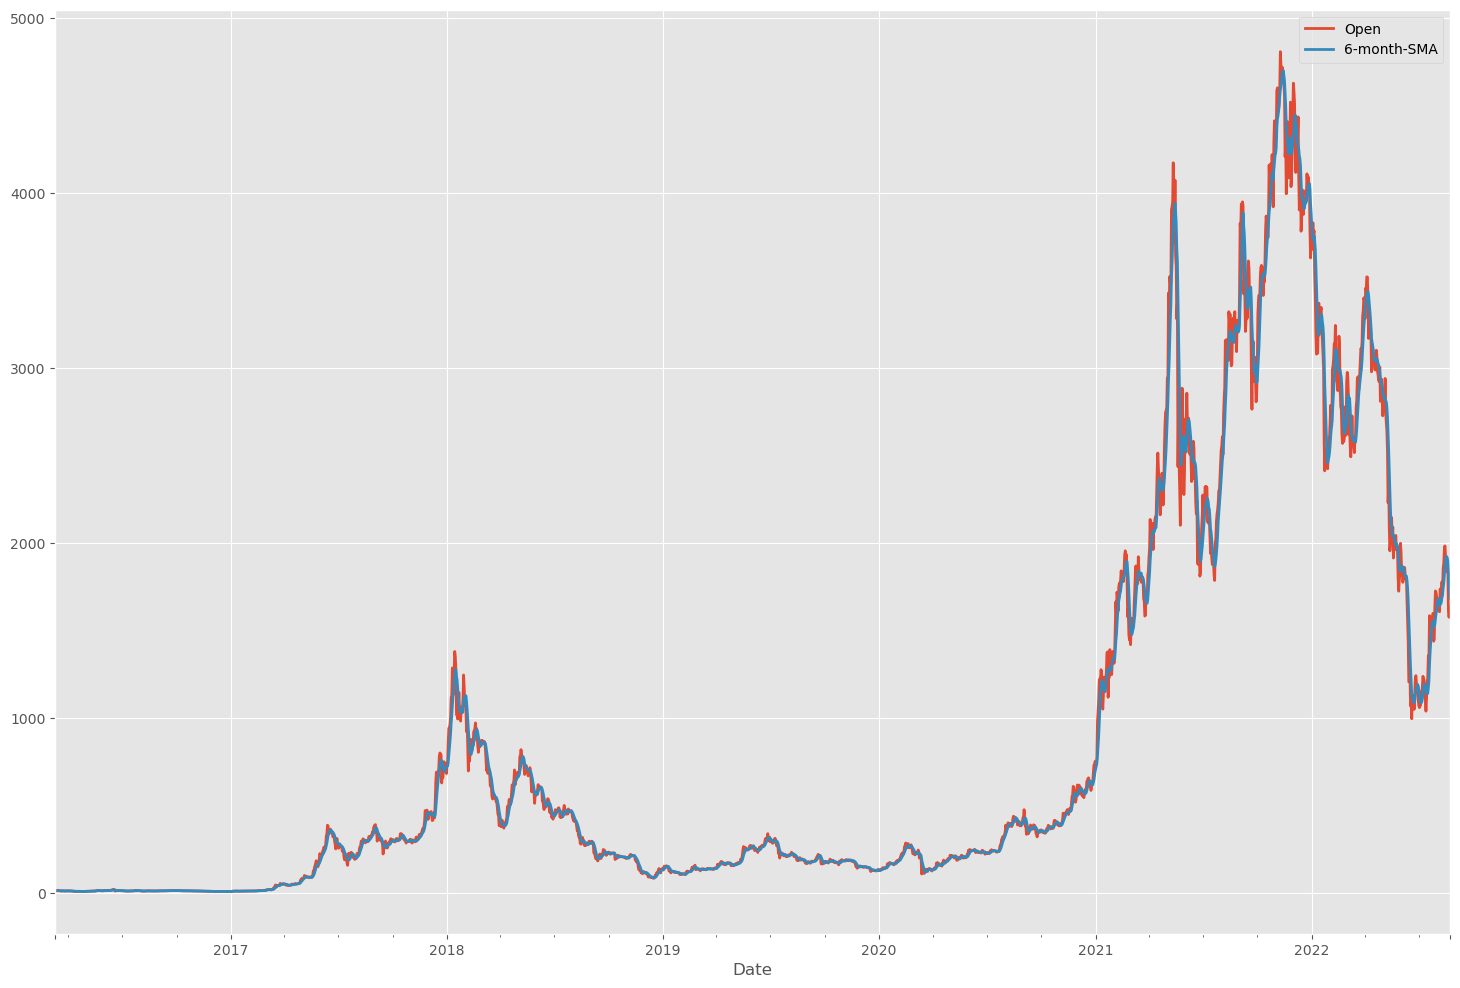

In [40]:
df[['Open','6-month-SMA']].plot(figsize=(18,12))

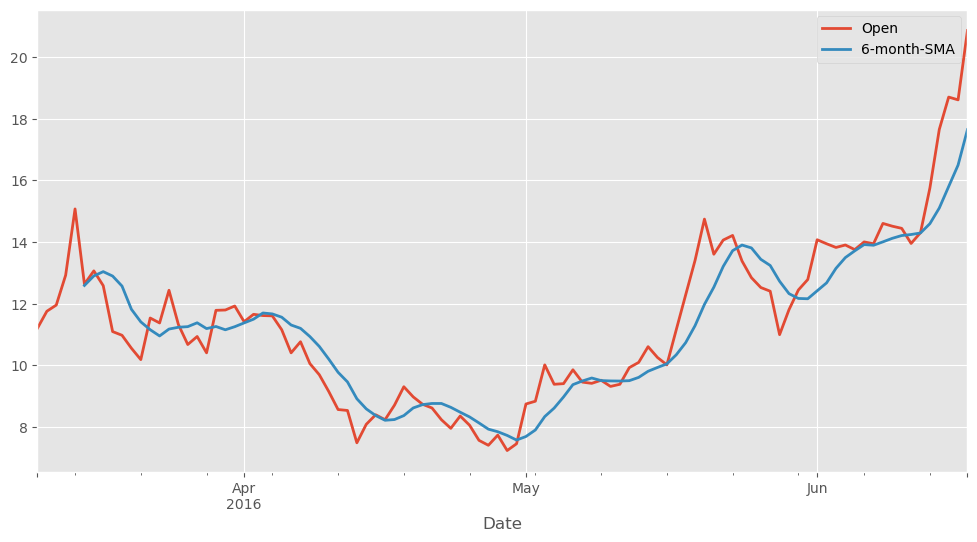

In [41]:
df[['Open', '6-month-SMA']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

In [42]:
df['EWM-A12'] = df['Open'].ewm(span=14, adjust=True).mean()

In [43]:
span = 8
alpha = 2/(span+1)

In [44]:
df['EWM-A12'] = df['Open'].ewm(alpha=alpha, adjust= False).mean()

In [45]:
model = SimpleExpSmoothing(df['Open'])

In [46]:
fitted_model = model.fit(smoothing_level = alpha, optimized = False)

In [47]:
#df[['Open', 'EWM-A12']].plot(figsize=(24,12));
fitted_model.fittedvalues

Date
2016-03-10      11.200000
2016-03-11      11.200000
2016-03-12      11.322222
2016-03-13      11.461728
2016-03-14      11.785789
                 ...     
2022-08-19    1865.211586
2022-08-20    1861.057900
2022-08-21    1805.047256
2022-08-22    1754.061199
2022-08-23    1723.872044
Freq: D, Length: 2358, dtype: float64

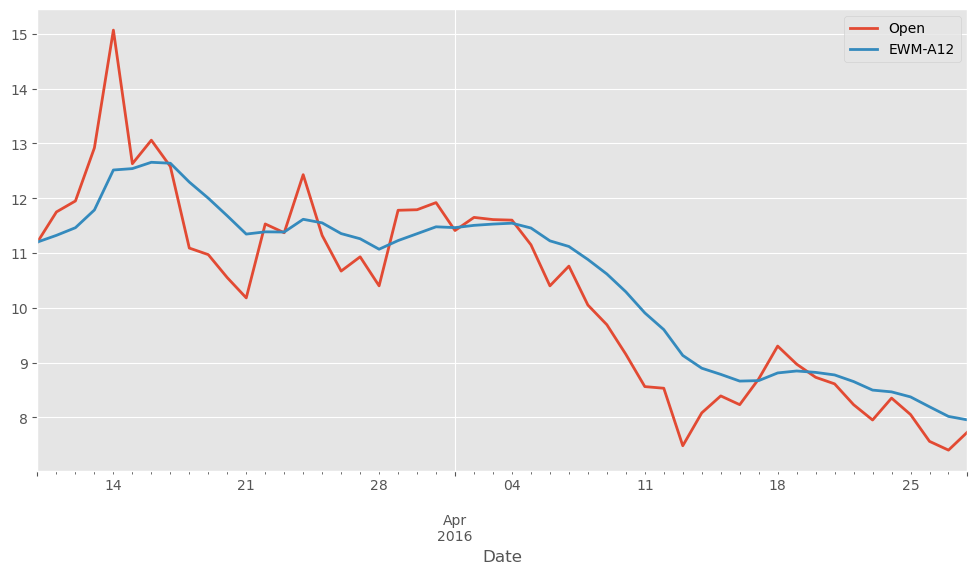

In [48]:
df[['Open','EWM-A12']].iloc[:50].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

In [49]:
fitted_model.fittedvalues.shift(-1)

Date
2016-03-10      11.200000
2016-03-11      11.322222
2016-03-12      11.461728
2016-03-13      11.785789
2016-03-14      12.515613
                 ...     
2022-08-19    1861.057900
2022-08-20    1805.047256
2022-08-21    1754.061199
2022-08-22    1723.872044
2022-08-23            NaN
Freq: D, Length: 2358, dtype: float64

In [50]:
df['SES12'] = fitted_model.fittedvalues.shift(-1)

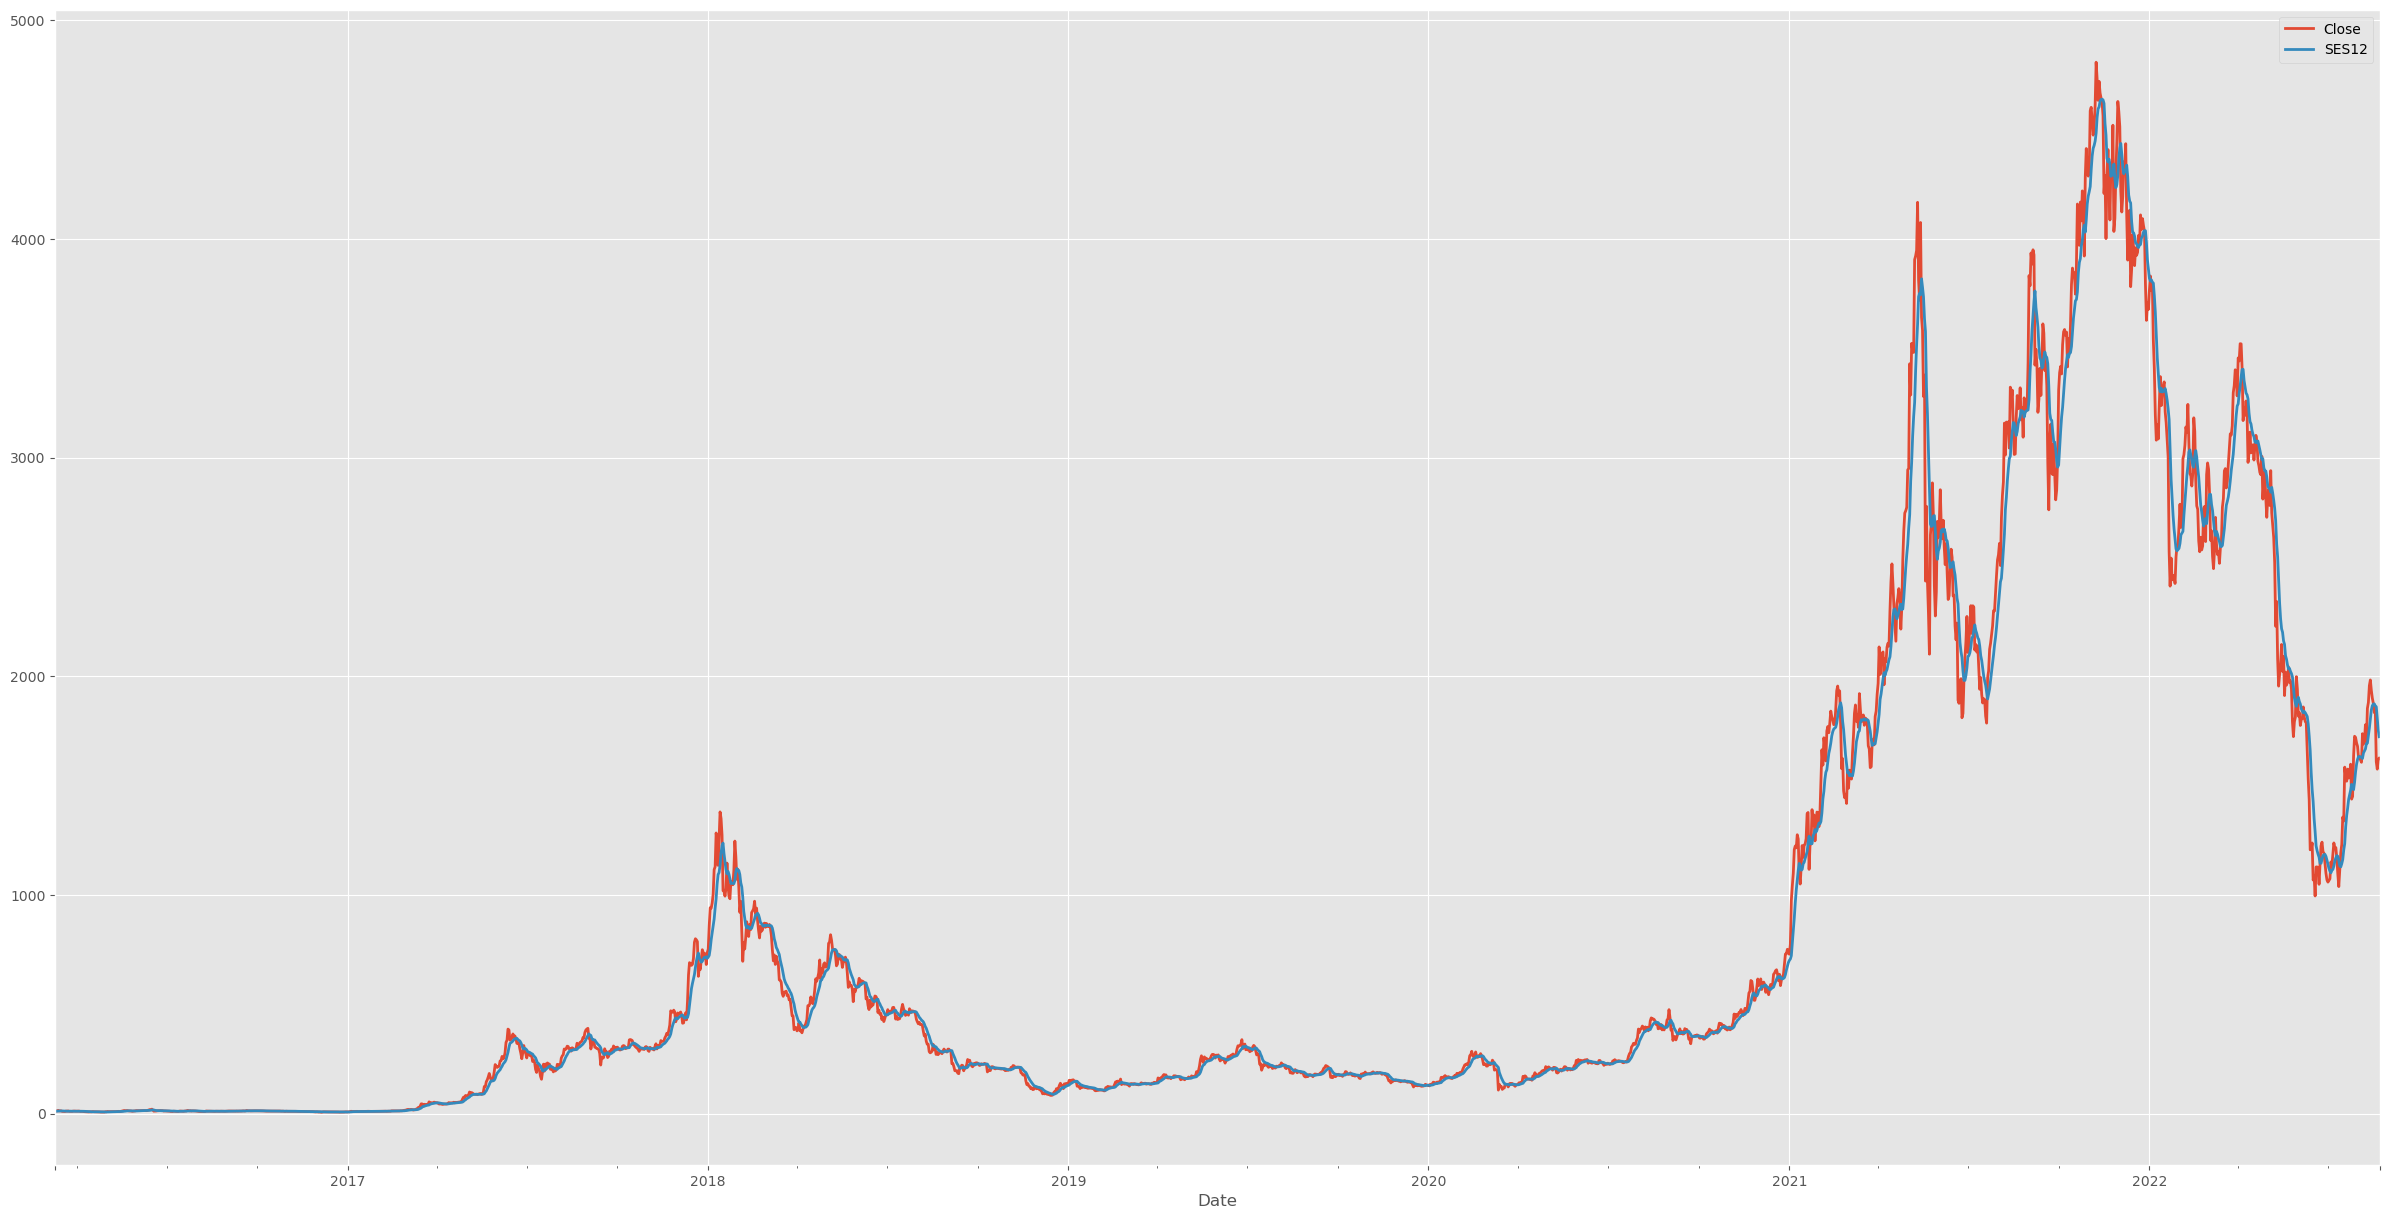

In [51]:
df[['Close','SES12']].plot(figsize=(30,15)).autoscale(axis='x', tight=True)

In [52]:
df['DESadd12'] = ExponentialSmoothing(df['Open'], trend='add').fit().fittedvalues.shift(-1)

In [53]:
df.head()

Open   High    Low  Close  Volume  Total Pov  Daily Return  \
Date                                                                      
2016-03-10  11.20  11.85  11.07  11.75       4      49.87           NaN   
2016-03-11  11.75  11.95  11.75  11.95     179     226.40      3.539803   
2016-03-12  11.95  13.45  11.95  12.92     833     883.27      2.901369   
2016-03-13  12.92  15.07  12.92  15.07    1295    1350.98      0.529521   
2016-03-14  15.07  15.07  11.40  12.50   92183   92237.04     67.274171   

            6-month-SMA  12-month-SMA  2-month-SMA    EWM-A12      SES12  \
Date                                                                       
2016-03-10          NaN           NaN          NaN  11.200000  11.200000   
2016-03-11          NaN           NaN       11.475  11.322222  11.322222   
2016-03-12          NaN           NaN       11.850  11.461728  11.461728   
2016-03-13          NaN           NaN       12.435  11.785789  11.785789   
2016-03-14          NaN           NaN       13.995  12.515613  12.515613   

             DESadd12  
Date                   
2016-03-10  12.030516  
2016-03-11  12.459313  
2016-03-12  12.676230  
2016-03-13  13.590385  
2016-03-14  15.648864

<AxesSubplot:xlabel='Date'>

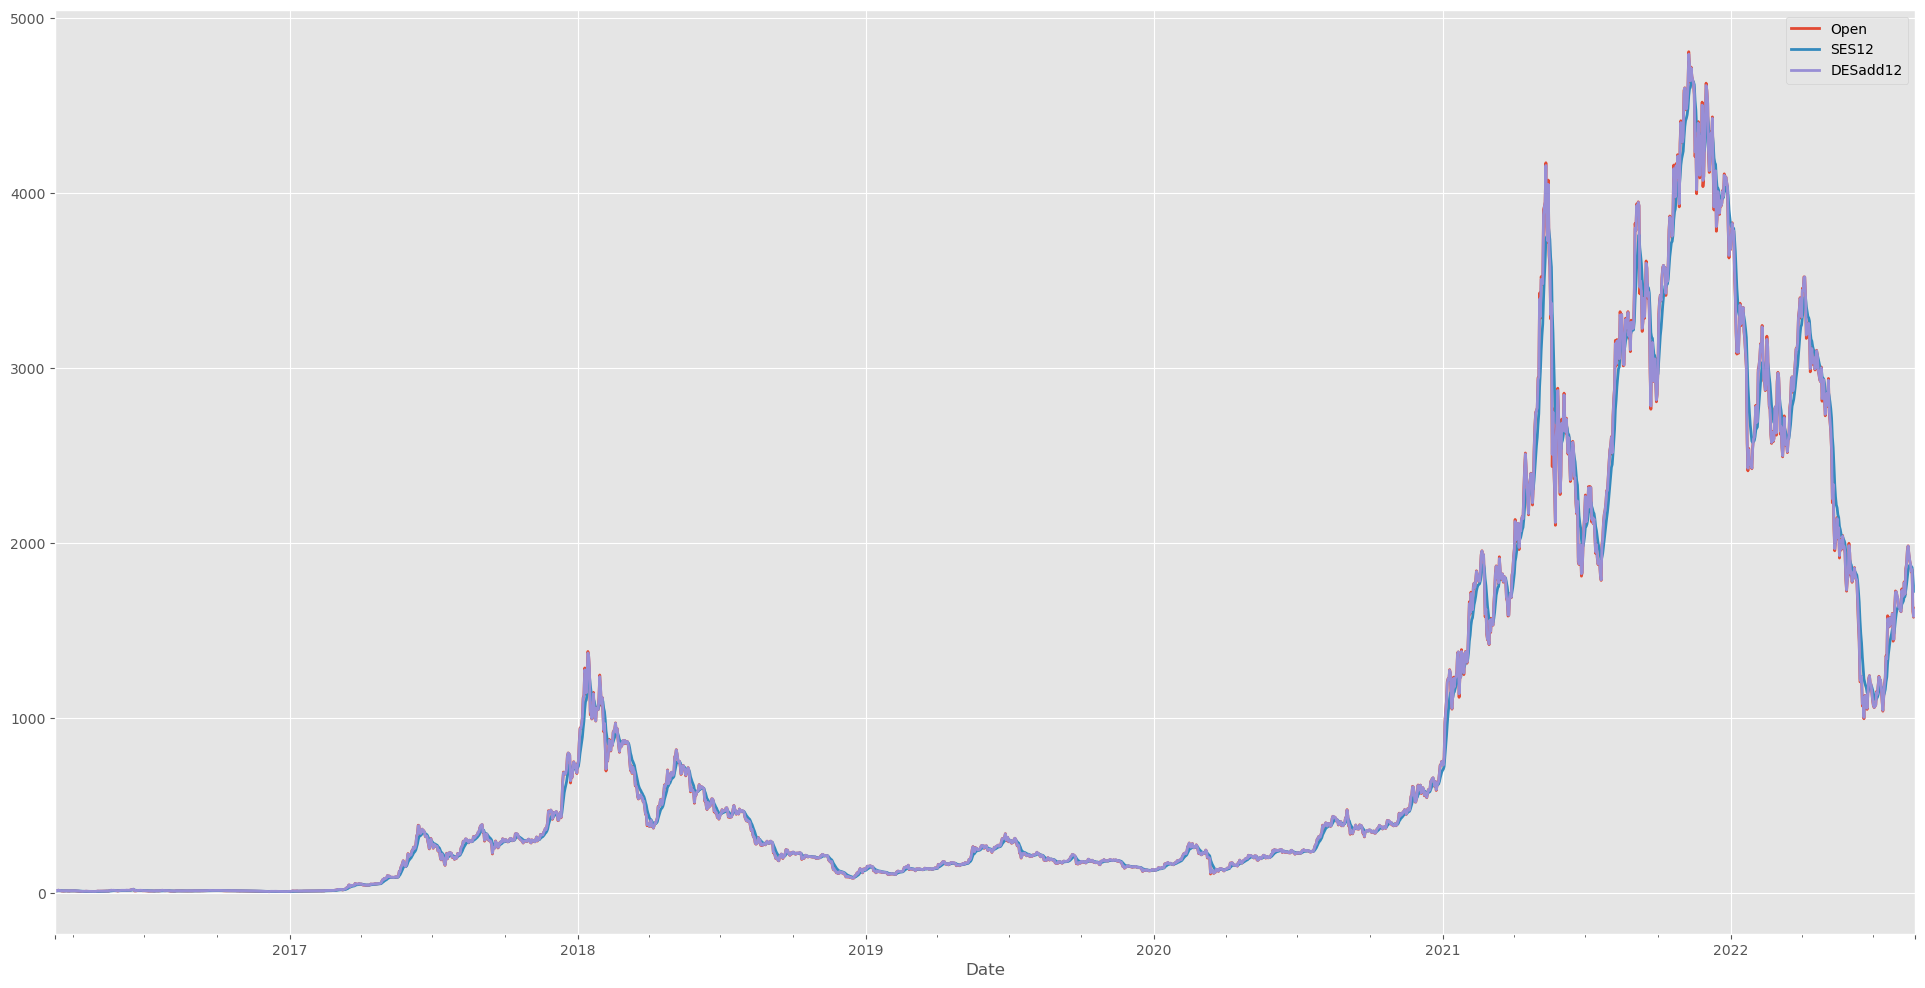

In [54]:
df[['Open', 'SES12', 'DESadd12']].plot(figsize=(24,12))

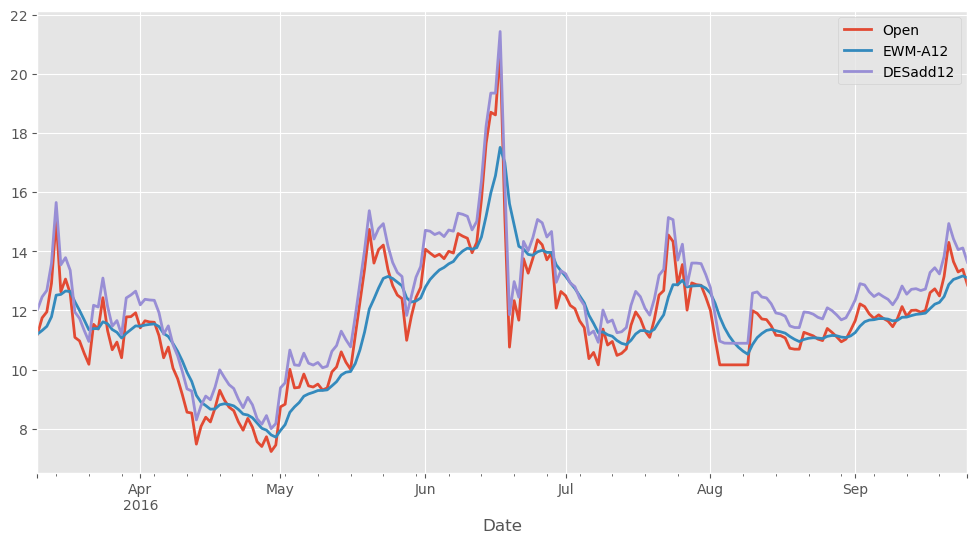

In [55]:
df[['Open', 'EWM-A12', 'DESadd12']].iloc[:200].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

In [56]:
df['DESmul-12'] = ExponentialSmoothing(df['Open'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

Open   High    Low  Close  Volume  Total Pov  Daily Return  \
Date                                                                      
2016-03-10  11.20  11.85  11.07  11.75       4      49.87           NaN   
2016-03-11  11.75  11.95  11.75  11.95     179     226.40      3.539803   
2016-03-12  11.95  13.45  11.95  12.92     833     883.27      2.901369   
2016-03-13  12.92  15.07  12.92  15.07    1295    1350.98      0.529521   
2016-03-14  15.07  15.07  11.40  12.50   92183   92237.04     67.274171   

            6-month-SMA  12-month-SMA  2-month-SMA    EWM-A12      SES12  \
Date                                                                       
2016-03-10          NaN           NaN          NaN  11.200000  11.200000   
2016-03-11          NaN           NaN       11.475  11.322222  11.322222   
2016-03-12          NaN           NaN       11.850  11.461728  11.461728   
2016-03-13          NaN           NaN       12.435  11.785789  11.785789   
2016-03-14          NaN           NaN       13.995  12.515613  12.515613   

             DESadd12  DESmul-12  
Date                              
2016-03-10  12.030516  11.265892  
2016-03-11  12.459313  11.681724  
2016-03-12  12.676230  11.897507  
2016-03-13  13.590385  12.808041  
2016-03-14  15.648864  14.858908

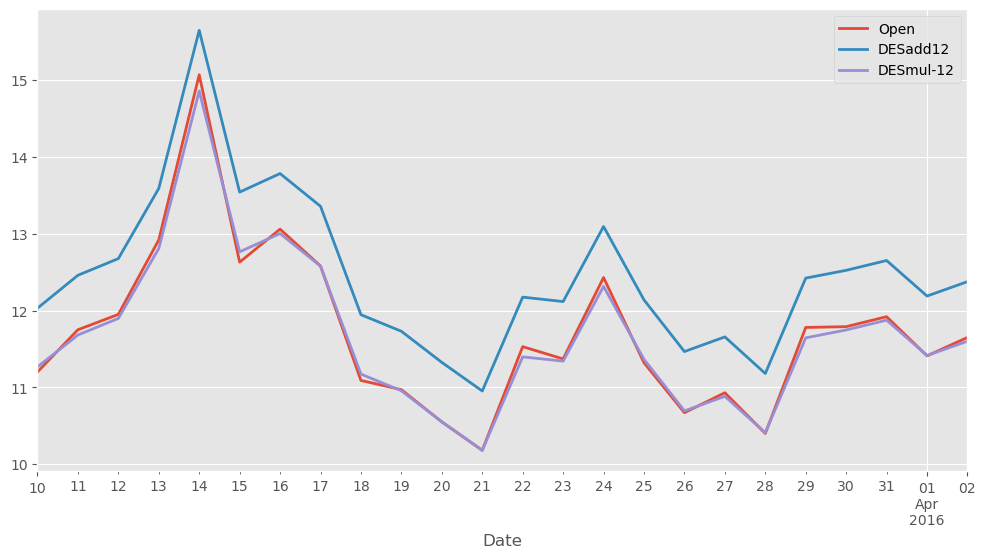

In [57]:
df[['Open','DESadd12','DESmul-12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

In [58]:
df['TESadd12'] = ExponentialSmoothing(df['Open'], trend = 'add', seasonal = 'add', seasonal_periods =12).fit().fittedvalues

In [59]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Total Pov', 'Daily Return',
       '6-month-SMA', '12-month-SMA', '2-month-SMA', 'EWM-A12', 'SES12',
       'DESadd12', 'DESmul-12', 'TESadd12'],
      dtype='object')

In [60]:
df['TESmul-12'] = ExponentialSmoothing(df['Open'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
df.head()

Open   High    Low  Close  Volume  Total Pov  Daily Return  \
Date                                                                      
2016-03-10  11.20  11.85  11.07  11.75       4      49.87           NaN   
2016-03-11  11.75  11.95  11.75  11.95     179     226.40      3.539803   
2016-03-12  11.95  13.45  11.95  12.92     833     883.27      2.901369   
2016-03-13  12.92  15.07  12.92  15.07    1295    1350.98      0.529521   
2016-03-14  15.07  15.07  11.40  12.50   92183   92237.04     67.274171   

            6-month-SMA  12-month-SMA  2-month-SMA    EWM-A12      SES12  \
Date                                                                       
2016-03-10          NaN           NaN          NaN  11.200000  11.200000   
2016-03-11          NaN           NaN       11.475  11.322222  11.322222   
2016-03-12          NaN           NaN       11.850  11.461728  11.461728   
2016-03-13          NaN           NaN       12.435  11.785789  11.785789   
2016-03-14          NaN           NaN       13.995  12.515613  12.515613   

             DESadd12  DESmul-12   TESadd12  TESmul-12  
Date                                                    
2016-03-10  12.030516  11.265892  13.303045  14.122721  
2016-03-11  12.459313  11.681724   7.945993  12.117438  
2016-03-12  12.676230  11.897507  13.338449  13.116533  
2016-03-13  13.590385  12.808041  19.069670   9.920051  
2016-03-14  15.648864  14.858908  12.992143  16.885120

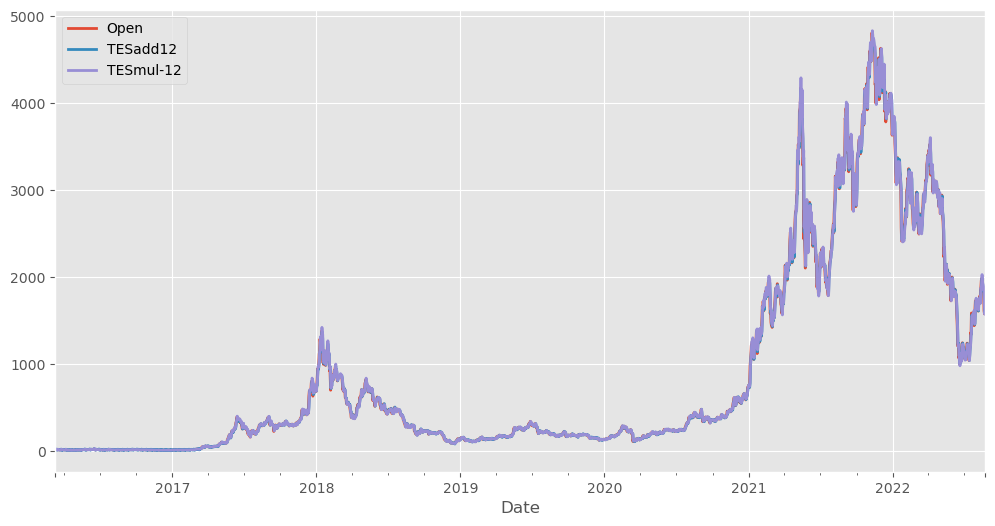

In [61]:
df[['Open', 'TESadd12', 'TESmul-12']].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

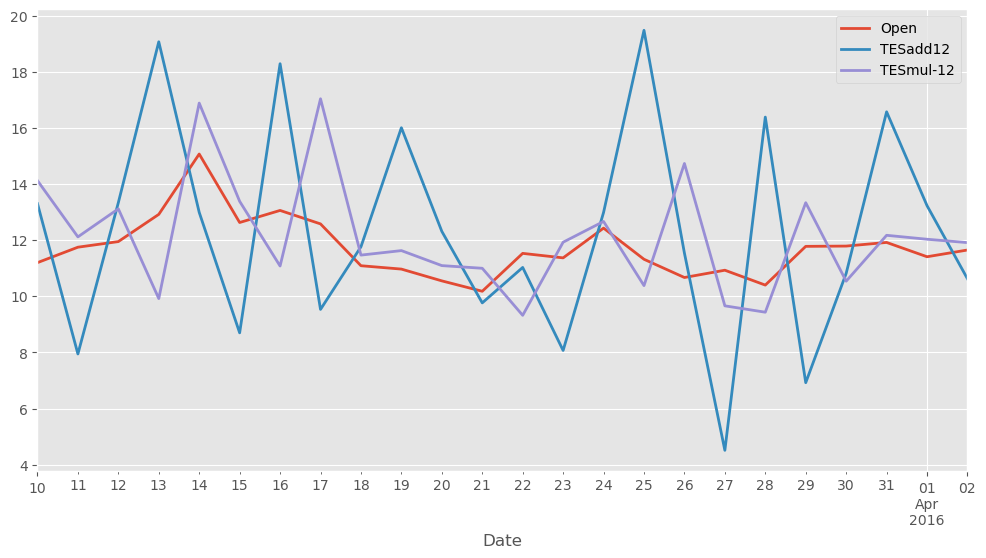

In [62]:
df[['Open', 'TESadd12', 'TESmul-12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

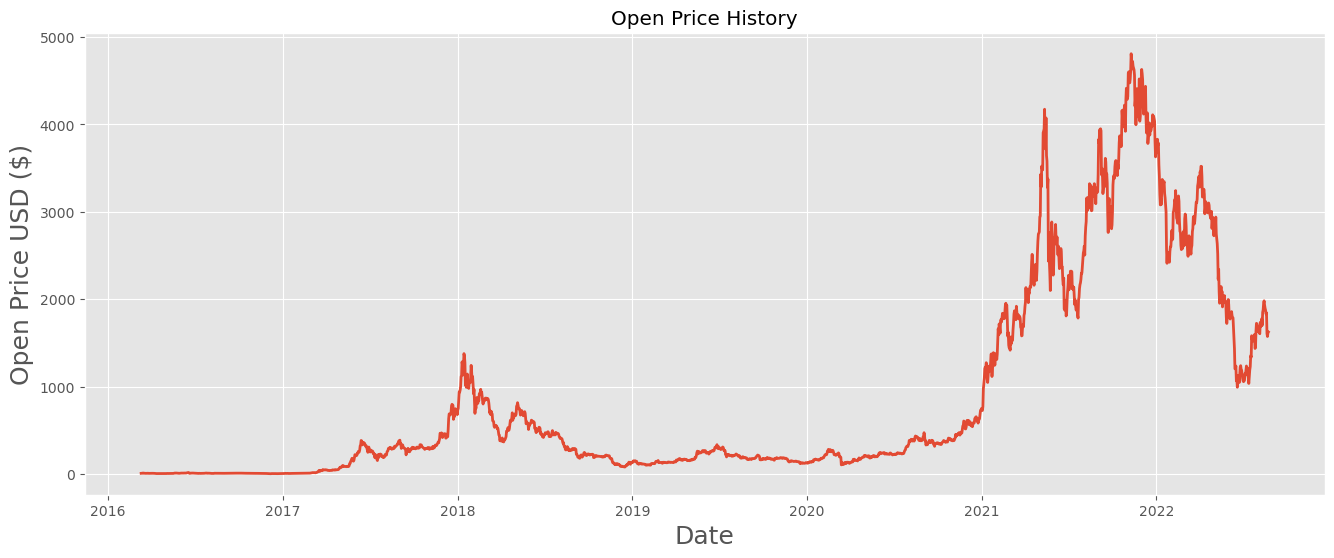

In [63]:
plt.figure(figsize=(16,6))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

# LSTM MODEL

In [64]:
#determining train set length
data = df.filter(['Open'])
dataset = data.values
training_data_len = int(np.ceil (len(dataset) * .80))
training_data_len

1887

In [65]:
#normalizing scale 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data
scaled_data.shape

(2358, 1)

In [66]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00094134, 0.00105588, 0.00109754, 0.00129955, 0.00174731,
       0.00123915, 0.00132871, 0.00122874, 0.00091843, 0.00089344,
       0.00080597, 0.00072891, 0.00101007, 0.00097675, 0.0011975 ,
       0.00096633, 0.00083096, 0.00088511, 0.00077473, 0.00106213,
       0.00106422, 0.00109129, 0.00098508, 0.00103506, 0.00102673,
       0.00102465, 0.00093093, 0.00077473, 0.00084971, 0.00070184,
       0.00062687, 0.00051441, 0.00039153, 0.00038528, 0.00016661,
       0.00029157, 0.00035613, 0.00032281, 0.00042069, 0.00054564,
       0.00047692, 0.00042694, 0.00040194, 0.00032281, 0.00026449,
       0.0003478 , 0.00028532, 0.00018327, 0.00014995, 0.00021867,
       0.00011454, 0.00016036, 0.00042902, 0.00044776, 0.00069351,
       0.00056231, 0.00056647, 0.00066019, 0.00057688, 0.00056855])]
[0.000589379506254087]

[array([0.00094134, 0.00105588, 0.00109754, 0.00129955, 0.00174731,
       0.00123915, 0.00132871, 0.00122874, 0.00091843, 0.00089344,
       0.00080597, 0.00072891, 0.0

In [67]:
x_train.shape

(1827, 60, 1)

In [68]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [69]:
x_test.shape

(471, 60, 1)

In [70]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(56, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 56)                27104     
                                                                 
 dense (Dense)               (None, 16)                912       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 44,929
Trainable params: 44,929
Non-trainable params: 0
_________________________________________________________________


In [71]:
callbacks = [EarlyStopping(patience=4, monitor='loss', mode='min'),ReduceLROnPlateau(patience=3, verbose=1)]

In [72]:
history = model.fit(x_train, y_train,epochs=50, batch_size=32, callbacks=[callbacks],)

Epoch 1/50
58/58 [==============================] - 5s 36ms/step - loss: 9.7384e-04 - lr: 0.0010
Epoch 2/50
58/58 [==============================] - 2s 35ms/step - loss: 2.3761e-04 - lr: 0.0010
Epoch 3/50
58/58 [==============================] - 2s 38ms/step - loss: 2.6878e-04 - lr: 0.0010
Epoch 4/50
58/58 [==============================] - 2s 35ms/step - loss: 2.2848e-04 - lr: 0.0010
Epoch 5/50
58/58 [==============================] - 2s 35ms/step - loss: 1.8751e-04 - lr: 0.0010
Epoch 6/50
58/58 [==============================] - 2s 36ms/step - loss: 2.0663e-04 - lr: 0.0010
Epoch 7/50
58/58 [==============================] - 2s 37ms/step - loss: 1.5758e-04 - lr: 0.0010
Epoch 8/50
58/58 [==============================] - 2s 35ms/step - loss: 1.7621e-04 - lr: 0.0010
Epoch 9/50
58/58 [==============================] - 2s 35ms/step - loss: 1.6225e-04 - lr: 0.0010
Epoch 10/50
58/58 [==============================] - 2s 35ms/step - loss: 1.8239e-04 - lr: 0.0010
Epoch 11/50
58/58 [==========

58/58 [==============================] - 2s 39ms/step - loss: 7.6663e-05 - lr: 0.0010
Epoch 29/50
58/58 [==============================] - 2s 38ms/step - loss: 7.5281e-05 - lr: 0.0010
Epoch 30/50
58/58 [==============================] - 2s 39ms/step - loss: 7.4686e-05 - lr: 0.0010
Epoch 31/50
58/58 [==============================] - 2s 39ms/step - loss: 9.7651e-05 - lr: 0.0010
Epoch 32/50
58/58 [==============================] - 2s 39ms/step - loss: 7.3439e-05 - lr: 0.0010
Epoch 33/50
58/58 [==============================] - 2s 39ms/step - loss: 8.5472e-05 - lr: 0.0010
Epoch 34/50
58/58 [==============================] - 2s 40ms/step - loss: 9.8727e-05 - lr: 0.0010
Epoch 35/50
58/58 [==============================] - 2s 39ms/step - loss: 7.8571e-05 - lr: 0.0010
Epoch 36/50
58/58 [==============================] - 2s 39ms/step - loss: 6.7230e-05 - lr: 0.0010
Epoch 37/50
58/58 [==============================] - 2s 39ms/step - loss: 9.3480e-05 - lr: 0.0010
Epoch 38/50
58/58 [=============

In [73]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

preds = model.predict(x_test)
preds = scaler.inverse_transform(preds)

rmse = np.sqrt(np.mean(((preds - y_test)**2)))
print ('Root Mean Squared Error',rmse)
print ('Mean Absolute Error',mean_absolute_error(y_test, preds))

15/15 [==============================] - 1s 16ms/step
Root Mean Squared Error 215.06011936944458
Mean Absolute Error 159.61597490379512


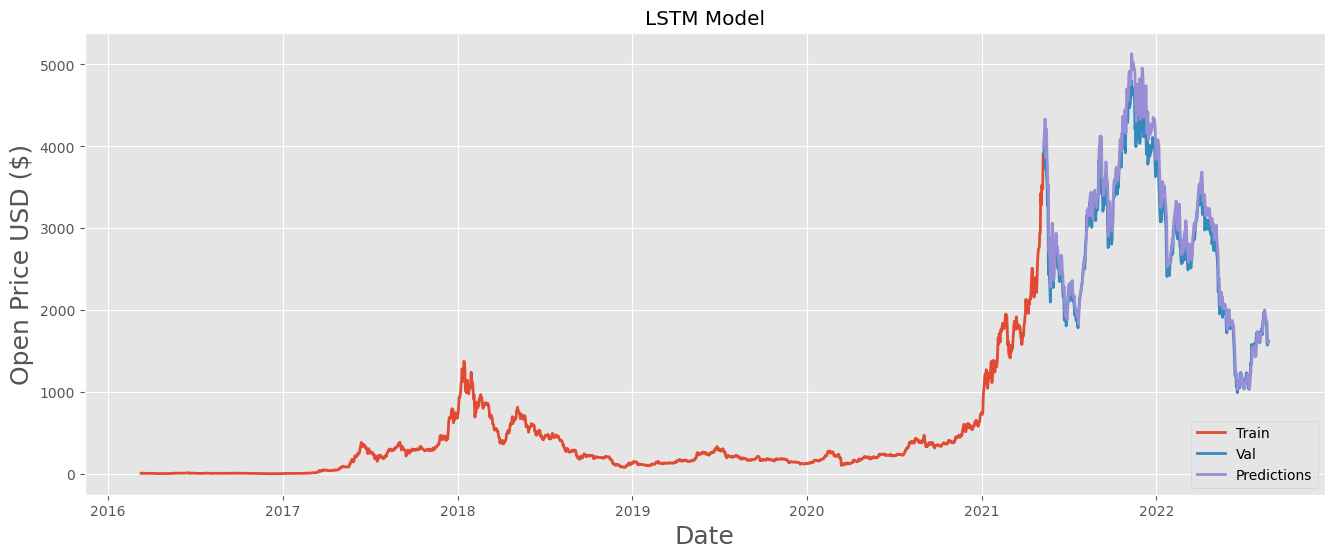

In [74]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds

plt.figure(figsize=(16,6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

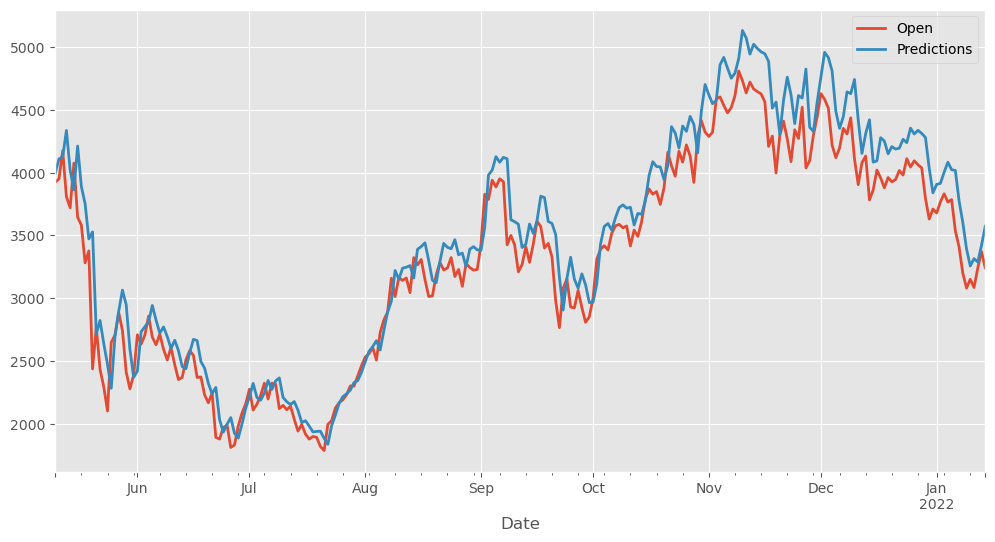

In [75]:
valid[['Open', 'Predictions']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x', tight = True);

# Gated Recurrent Unit (GRU)

In [76]:
model2 = Sequential()
model2.add(GRU(64, return_sequences=True, input_shape=(x_train.shape[1],1)))
model2.add(GRU(52, return_sequences=False))
model2.add(Dense(16))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(optimizer='rmsprop', loss='mean_squared_error',metrics='mean_squared_error')
model2.summary()

#model2.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mae','mse'])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 64)            12864     
                                                                 
 gru_1 (GRU)                 (None, 52)                18408     
                                                                 
 dense_2 (Dense)             (None, 16)                848       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,137
Trainable params: 32,137
Non-trainable params: 0
_________________________________________________________________


In [77]:
model2.fit(x_train, y_train, epochs=40, batch_size=32,)

Epoch 1/40
58/58 [==============================] - 5s 37ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2/40
58/58 [==============================] - 2s 34ms/step - loss: 7.3124e-04 - mean_squared_error: 7.3124e-04
Epoch 3/40
58/58 [==============================] - 2s 35ms/step - loss: 7.6486e-04 - mean_squared_error: 7.6486e-04
Epoch 4/40
58/58 [==============================] - 2s 34ms/step - loss: 6.4827e-04 - mean_squared_error: 6.4827e-04
Epoch 5/40
58/58 [==============================] - 2s 35ms/step - loss: 5.7852e-04 - mean_squared_error: 5.7852e-04
Epoch 6/40
58/58 [==============================] - 2s 34ms/step - loss: 5.4479e-04 - mean_squared_error: 5.4479e-04
Epoch 7/40
58/58 [==============================] - 2s 35ms/step - loss: 5.3159e-04 - mean_squared_error: 5.3159e-04
Epoch 8/40
58/58 [==============================] - 2s 34ms/step - loss: 5.6995e-04 - mean_squared_error: 5.6995e-04
Epoch 9/40
58/58 [==============================] - 2s 38ms/step - loss:

In [149]:
preds_gru = model2.predict(x_test)
preds_gru = scaler.inverse_transform(preds_gru)

rmse = np.sqrt(np.mean(((preds_gru - y_test)**2)))
print ('Root Mean Squared Error',rmse)
print ('Mean Absolute Error',mean_absolute_error(y_test, preds_gru))

11/11 [==============================] - 1s 14ms/step
Root Mean Squared Error 2.429299125570963
Mean Absolute Error 1.7994910078950461


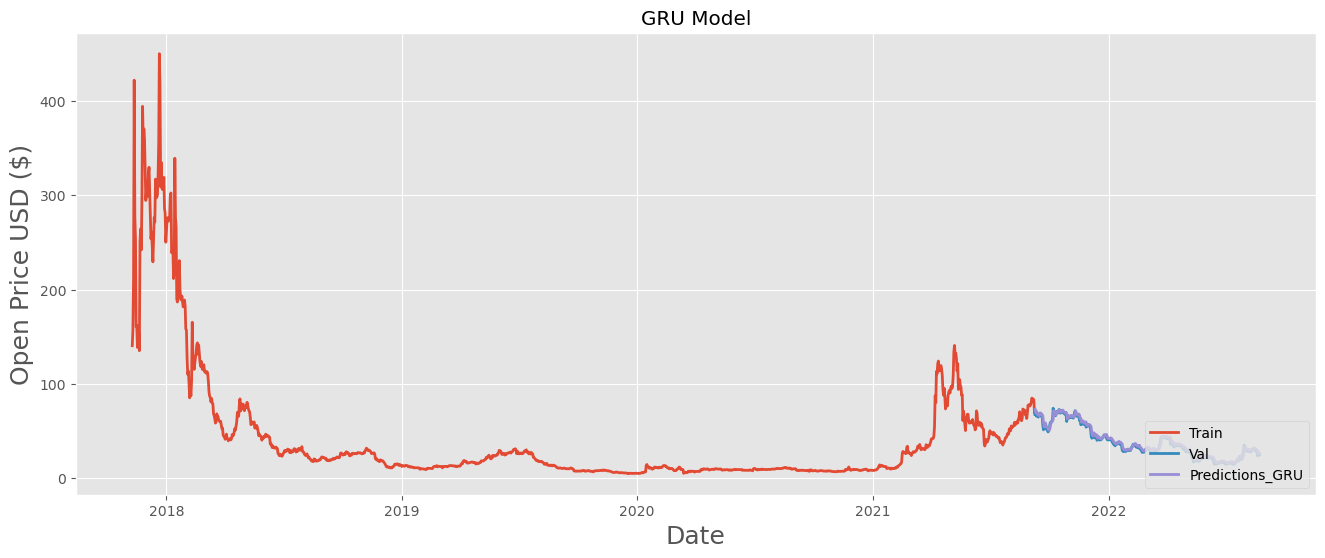

In [150]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions_GRU'] = preds_gru

plt.figure(figsize=(16,6))
plt.title('GRU Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions_GRU']])
plt.legend(['Train', 'Val', 'Predictions_GRU'], loc='lower right')
plt.show()

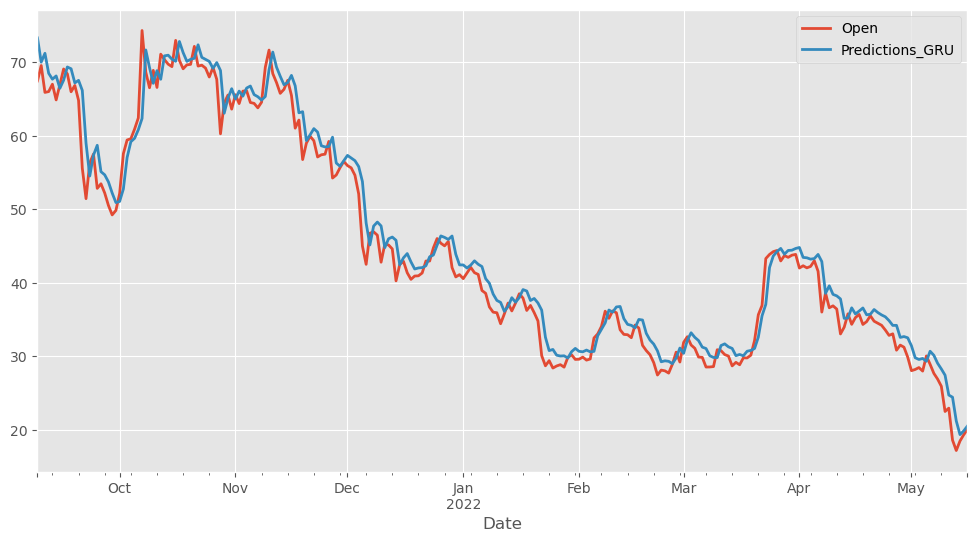

In [151]:
valid[['Open', 'Predictions_GRU']].iloc[:250].plot(figsize=(12,6)).autoscale(axis='x', tight = True);